# Telegram Spam Classifier
Detect if a message is spam or not.


In [36]:
import warnings
warnings.filterwarnings("ignore")
_
# General
import re
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import Counter
_
# EDA
import matplotlib.pyplot as plt
import seaborn as sns
# Set style and plot size
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = [15, 5]

Load in data:

In [37]:
df = pd.read_csv('original_data/msg_data.csv')
_
df.sample(5)

,text_type,text
16735,spam,opportunity to own flat in sec137 xpresway noi...
15870,ham,i m lyng on bed mene lunch kar liya h tune kr ...
1317,spam,we focus on oem and retail box for microsoft a...
8093,spam,here it is zzzz mortgage companies make you wa...
376,spam,x 2 o automated wealth builder 511771 the trut...


### Cleaning

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20348 entries, 0 to 20347
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text_type  20348 non-null  object
 1   text       20348 non-null  object
dtypes: object(2)
memory usage: 318.1+ KB


Value counts for `text_type`:

In [39]:
df['text_type'].value_counts()

text_type
ham     14337
spam     6011
Name: count, dtype: int64

Remove duplicated values:

In [40]:
df = df[~df.duplicated(keep='first', subset=['text'])]

Not a lot to clean up with this dataset. Let's move on to engineering.

### Preprocessing

Word count for each message:

In [41]:
# Frist, remove additional whitespace:
df['text'] = df['text'].apply(lambda x: re.sub("\s+", ' ', x))
# Word count:
df['word_count'] = df['text'].apply(lambda x: len(x.split(' ')))
_
df.sample(5)

,text_type,text,word_count
4330,ham,rankings thank you,3
566,spam,jif,1
20014,ham,memes,1
1348,spam,wall street micro news report homeland securit...,116
3514,ham,john martin baylor cindy i am in wharton on de...,143


Plot word counts:

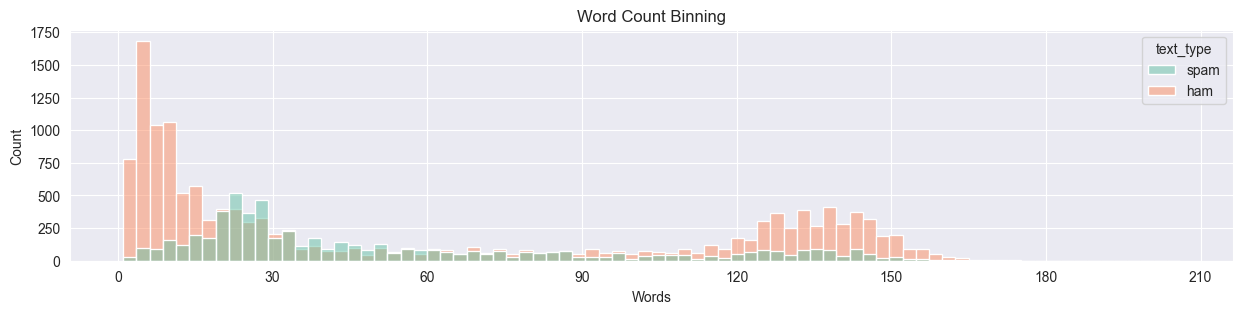

In [42]:
plt.figure(figsize=(15, 3))
plt.title(f"Word Count Binning")
sns.histplot(data=df, x='word_count', hue='text_type', palette='Set2', bins=80)
plt.xlabel("Words")
plt.xticks([i for i in range(0, 240, 30)])
plt.show()

Ham messages are usually shorter than spam.

### Text Preprocessing

WordClouds:

In [43]:
from wordcloud import WordCloud

Compile a new dataframe corpus for each text type:

In [44]:
data_dict = {}
for text_type in df['text_type'].unique():
    text_type_corpus = " ".join(df[df['text_type'] == text_type]['text'])
    data_dict[text_type] = [text_type_corpus]
_
class_corpus = (
    pd.DataFrame(data_dict)
    .T
    .reset_index()
    .rename(columns={'index': 'class', 0: 'vocab'})
)

WordClouds before text preprocessing:

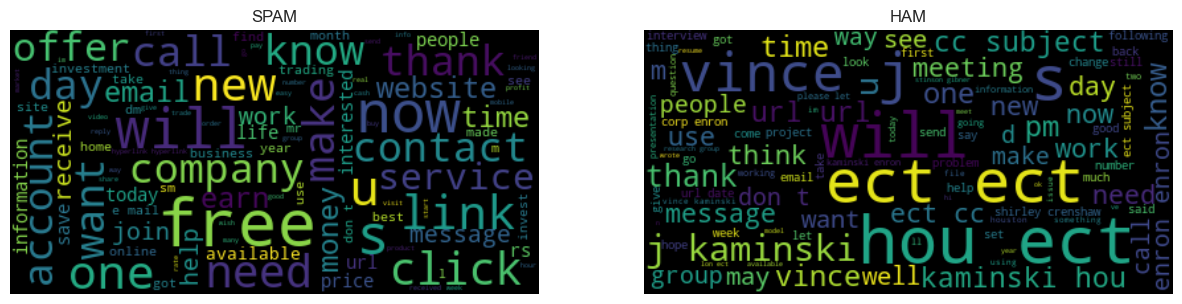

In [45]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="black")
_
for i, text in enumerate(class_corpus['vocab']):
    wordcloud.generate(text)
    plt.subplot(1, len(df['text_type'].unique()), i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"{class_corpus['class'][i].upper()}")
    plt.axis("off")

plt.show()

Vocabulary size:

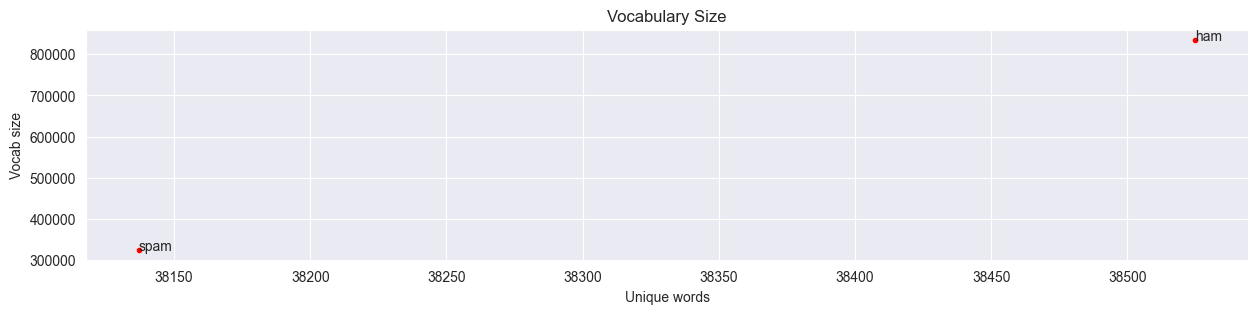

In [46]:
class_corpus['vocab_size'] = class_corpus['vocab'].apply(lambda x: len(x.split(' ')))
class_corpus['unique_words']  = class_corpus['vocab'].apply(lambda x: len(set(x.split(' '))))
_
# Plot vocab size:
plt.figure(figsize=(15, 3))
plt.title(f"Vocabulary Size")
ax = sns.scatterplot(data=class_corpus, x='unique_words', y='vocab_size', color='red', s=20)
for i, class_ in enumerate(class_corpus['class']):
    ax.text(class_corpus['unique_words'][i], class_corpus['vocab_size'][i], class_, ha="left", va='baseline')

plt.xlabel('Unique words')
plt.ylabel('Vocab size')
plt.show()

Profanity:

In [47]:
# I'll be using only general swears :D
for index, row in class_corpus.iterrows():
    word_list = set(row['vocab'].split(' '))
    word_counts = Counter(word_list)

    # Indentify words with these prefixes:
    for prefix in ['fuck', 'bitch', 'shit', 'dick', 'pussy', 'cunt', 'slut', 'porn']:
        tally = 0
        for word, count in word_counts.items():
            if prefix in word:
                tally += 1
                
        # Store count
        class_corpus.loc[index, f"{prefix} count"] = tally

_
class_corpus

,class,vocab,vocab_size,unique_words,fuck count,bitch count,shit count,dick count,pussy count,cunt count,slut count,porn count
0,spam,naturally irresistible your corporate identity...,323425,38137,5.0,3.0,5.0,4.0,1.0,0.0,3.0,20.0
1,ham,hello guys i m bugging you for your completed ...,834282,38525,11.0,5.0,19.0,9.0,3.0,2.0,1.0,6.0


### NLP

In [48]:
import nltk
from nltk import pos_tag
from nltk.corpus import words
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from unicodedata import normalize
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

Instantiate stop words:

In [49]:
with open('stop_words/updated_stop_words.txt') as file:
    updated_stop_words = file.read().split('\n')
    stop_words_temp = stopwords.words('english') + updated_stop_words
_
STOP_WORDS = set([word.replace("'", '') for word in stop_words_temp])

Clean text and indentify valid words:

In [50]:
def clean_text(text: str) -> str:
    """
    Remove punctuation, symbols, and numbers.
    """
    text = text.lower()
    text = re.sub("[0-9]", '', text)  # Remove numbers
    text = re.sub("[^\w ]+", ' ', text)  # Remove special symbols
    text = re.sub("_", '', text)  # Remove underscores
    text = normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')  # Remove accented characters
    text = valid_words(text)  # Remove invalid words from text
    return text


def valid_words(text: str) -> str:
    """
    Identify valid words in text.
    """
    dictionary = set(words.words())
    word_tokens = word_tokenize(text)
    valid_words = [word for word in word_tokens if word in dictionary]
    text = " ".join(valid_words)
    return text

Lemmatize and remove stop words:

In [51]:
def get_wordnet_pos(treebank_tag):
    """
    Converts part-of-speech tag into wordnet tag if able.
    """
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None


def lemmatize(text: str) -> str:
    """
    Lemmatize words.
    """
    lem = WordNetLemmatizer()
    word_tags = pos_tag(word_tokenize(text))

    text = [
        lem.lemmatize(word[0], pos=get_wordnet_pos(word[1])) \
        if word[1].startswith(('J', 'V', 'N', 'R')) else word[0] for word in word_tags
    ]
    text = remove_stop_words(text)
    return text


def remove_stop_words(text: list) -> str:
    """
    Remove stop words from text.
    """
    valid_words = [word for word in text if word not in STOP_WORDS]
    text = " ".join(valid_words)
    return text

Process text:

In [52]:
for index, row in tqdm(df.iterrows(), total=len(df)):
    text = row['text']
    text = clean_text(text)
    text = lemmatize(text)
    
    df.loc[index, 'nlp_text'] = text

  0%|          | 0/20334 [00:00<?, ?it/s]

Remove text entries with a word count of 5 or less:

In [53]:
df = df[df['nlp_text'].apply(lambda x: len(x.split(' ')) > 5)]
df['nlp_text'] = df['nlp_text'].apply(lambda x: " ".join([word for word in x.split(' ') if len(word) > 1]))

In [54]:
# Save checkpoint:
df.to_csv('processed_data/msg_data_processed.csv', index=False)

In [55]:
# Load data:
df = pd.read_csv('processed_data/msg_data_processed.csv')
df = df.dropna()

WordClouds post text preprocessing:

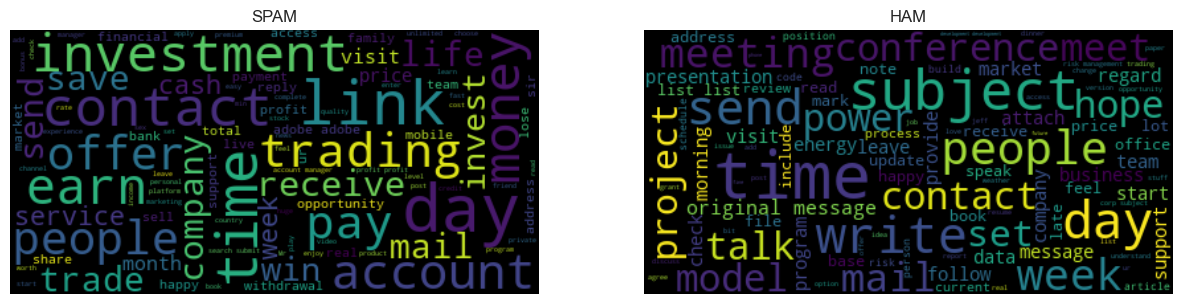

In [56]:
data_dict = {}
for text_type in df['text_type'].unique():
    text_type_corpus = " ".join(df[df['text_type'] == text_type]['nlp_text'])
    data_dict[text_type] = [text_type_corpus]
_
class_corpus = (
    pd.DataFrame(data_dict)
    .T
    .reset_index()
    .rename(columns={'index': 'class', 0: 'vocab'})
)
_
for i, text in enumerate(class_corpus['vocab']):
    wordcloud.generate(text)
    plt.subplot(1, len(df['text_type'].unique()), i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"{class_corpus['class'][i].upper()}")
    plt.axis("off")

plt.show()

Most common words by `text_type`:

In [57]:
for index, text in enumerate(class_corpus['vocab']):
    word_counts = Counter(text.split(' '))
    print(class_corpus['class'][index], word_counts.most_common(10), '\n')

spam [('day', 661), ('link', 656), ('time', 631), ('receive', 590), ('money', 588), ('company', 549), ('business', 547), ('account', 517), ('earn', 511), ('contact', 471)] 

ham [('subject', 2596), ('time', 1771), ('list', 1307), ('write', 1299), ('send', 1284), ('message', 1134), ('day', 980), ('mail', 846), ('corp', 774), ('meeting', 770)] 



### Text Classification

In [58]:
# ML
import pickle
from random import uniform
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, log_loss
# Models
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import ComplementNB
from sklearn.naive_bayes import BernoulliNB

Target label distribution:

In [59]:
df['text_type'].value_counts()

text_type
ham     7335
spam    4307
Name: count, dtype: int64

Encode `text_type`:

In [60]:
le = LabelEncoder()

In [61]:
df['text_type_encoded'] = le.fit_transform(df['text_type'])

Sort X, y:

In [62]:
X, y = df['nlp_text'], df['text_type_encoded']

#### Train, Test, Split

In [63]:
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.30, random_state=42)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.20, random_state=42)
_
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (8149,)
y_train shape: (8149,)
X_cv shape: (2794,)
y_cv shape: (2794,)
X_test shape: (699,)
y_test shape: (699,)


#### Training

In [64]:
# Instantiate TD-iDF vectotrizer:
vectorizer = TfidfVectorizer(
    max_df=0.3, 
    min_df=4, 
    stop_words='english', 
    lowercase=True, 
    use_idf=True, 
    norm='l2', 
    smooth_idf=True,
    strip_accents='unicode'
)
td_idf = vectorizer.fit_transform(X_train)

# Convert to dataframe:
columns = vectorizer.get_feature_names_out()
values = td_idf.toarray()
X_train_tdm = pd.DataFrame(values, columns=columns)
_
n_rows, n_cols = X_train_tdm.shape
print(f"Rows: {n_rows}, columns: {n_cols}\n")
X_train_tdm.head()

Rows: 8149, columns: 4044



,aa,abandon,ability,absence,absolute,absolutely,absorb,abstract,abstraction,absurd,...,yo,yoga,york,youth,yr,yuck,zee,zimbabwe,zip,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [65]:
def tdm_converter(vect: object, docs: list) -> np.array:
    """
    Convert vectorized documents into a text document matrix.
    """
    vect_transformer = vect.transform(docs)
    return vect_transformer.toarray()


def display_metrics(model_name: str, y_true: list, y_hat: list, y_hat_probas: list):
    """
    Displays numerous metrics about current model predictions.
    """
    print(f"Model: {model_name}")
    print(f"Accuracy score: {accuracy_score(y_true, y_hat)}")
    print(f"Recall score: {recall_score(y_true, y_hat, average='macro')}")
    print(f"Precision score: {precision_score(y_true, y_hat, average='macro')}")
    print(f"f1 score: {f1_score(y_true, y_hat, average='macro')}")
    try:
        print(f"Log loss {log_loss(y_true, y_hat_probas, labels=y_true)}")
        print(f"ROC AUC: {roc_auc_score(y_true, y_hat_probas, multi_class='ovr')}")
    except Exception as e:
        print(f"Error: {e}")

_
models = {'NB': MultinomialNB(), 'CompNB': ComplementNB(), 'BernoulliNB': BernoulliNB()}
X_cv_tdm = tdm_converter(vectorizer, X_cv)
_
# Get baseline metrics for each model
for name, model in models.items():
    model.fit(X_train_tdm, y_train)
    # Preprocess X_cv data
    y_pred = model.predict(X_cv_tdm)
    y_probas = model.predict_proba(X_cv_tdm)
    display_metrics(name, y_cv, y_pred, y_probas)
    print(f"-------------------------------------")

Model: NB
Accuracy score: 0.9234073013600572
Recall score: 0.910571180615976
Precision score: 0.9231923791953857
f1 score: 0.9162267251312539
Log loss 0.21822648558199792
Error: y should be a 1d array, got an array of shape (2794, 2) instead.
-------------------------------------
Model: CompNB
Accuracy score: 0.9216177523264137
Recall score: 0.9220390413830706
Precision score: 0.9121560820871366
f1 score: 0.9165425824653577
Log loss 0.23035795516585825
Error: y should be a 1d array, got an array of shape (2794, 2) instead.
-------------------------------------
Model: BernoulliNB
Accuracy score: 0.9101646385110952
Recall score: 0.9134302048410343
Precision score: 0.899174880525687
f1 score: 0.904974060393004
Log loss 0.29077676834239247
Error: y should be a 1d array, got an array of shape (2794, 2) instead.
-------------------------------------


#### Parameter Tuning

In [66]:
model_params = {
    # NB parameters
    'NB': {
        'alpha': set([uniform(0.0, 1.0) for _ in range(500)]),
    },
    # Complement NB parameters
    'CompNB': {
        'alpha': set([uniform(0.0, 1.0) for _ in range(500)]),
    },
    # Bernoull NB parameter
    'BernoulliNB': {
        'alpha': set([uniform(0.0, 1.0) for _ in range(500)])
    }
}

Run grid search:

In [67]:
grid_results = {
    'model': [],
    'alpha': [],
    'accuracy_score': [], 
    'recall_score': [], 
    'precision_score': [], 
    'f1_score': [],
    'log_loss': []
}
_
for name, model in models.items():
    print(f"Fitting {name}...")
    for alpha_val in tqdm(model_params[name]['alpha'], total=len(model_params[name]['alpha'])):
        if name == 'NB':
            test_model = MultinomialNB(alpha=alpha_val, force_alpha=True)
        elif name == 'CompNB':
            test_model = ComplementNB(alpha=alpha_val, force_alpha=True)
        else:
            test_model = BernoulliNB(alpha=alpha_val, force_alpha=True)

        # Fit model with current parameters:
        test_model.fit(X_train_tdm, y_train)

        # Run metrics on test set:
        y_pred = test_model.predict(X_cv_tdm)
        y_probas = test_model.predict_proba(X_cv_tdm)
    
        acc_score = accuracy_score(y_cv, y_pred)
        re_score = recall_score(y_cv, y_pred, average='macro')
        prec_score = precision_score(y_cv, y_pred, average='macro')
        f1 = f1_score(y_cv, y_pred, average='macro')
        log_loss_val = log_loss(y_cv, y_probas, labels=y_cv)
        # roc_auc_val = roc_auc_score(y_cv, y_probas, multi_class='ovr')
    
        # Store results in data dict:
        grid_results['model'].append(name)
        grid_results['alpha'].append(alpha_val)
        grid_results['accuracy_score'].append(acc_score)
        grid_results['recall_score'].append(re_score)
        grid_results['f1_score'].append(f1)
        grid_results['precision_score'].append(prec_score)
        grid_results['log_loss'].append(log_loss_val)
        # grid_results['roc_auc'].append(roc_auc_val)
_
print(f"\nFitting complete!")

Fitting NB...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting CompNB...


  0%|          | 0/500 [00:00<?, ?it/s]

Fitting BernoulliNB...


  0%|          | 0/500 [00:00<?, ?it/s]


Fitting complete!


#### Results

In [68]:
# View results
results = pd.DataFrame(grid_results).sort_values(['f1_score'], ascending=False)
results.head(10)

# 0.926271
# 0.928060 — 0.336583

,model,alpha,accuracy_score,recall_score,precision_score,f1_score,log_loss
497,NB,0.339449,0.928060,0.916522,0.927410,0.921477,0.195940
457,NB,0.337151,0.928060,0.916522,0.927410,0.921477,0.195861
71,NB,0.337387,0.928060,0.916522,0.927410,0.921477,0.195869
499,NB,0.365257,0.927702,0.916032,0.927117,0.921068,0.196831
190,NB,0.350266,0.927702,0.916032,0.927117,0.921068,0.196312
229,NB,0.353998,0.927702,0.916032,0.927117,0.921068,0.196441
258,NB,0.377448,0.927702,0.916032,0.927117,0.921068,0.197256
255,NB,0.374716,0.927702,0.916032,0.927117,0.921068,0.197161
28,NB,0.375385,0.927702,0.916032,0.927117,0.921068,0.197184
168,NB,0.346201,0.927702,0.916032,0.927117,0.921068,0.196172


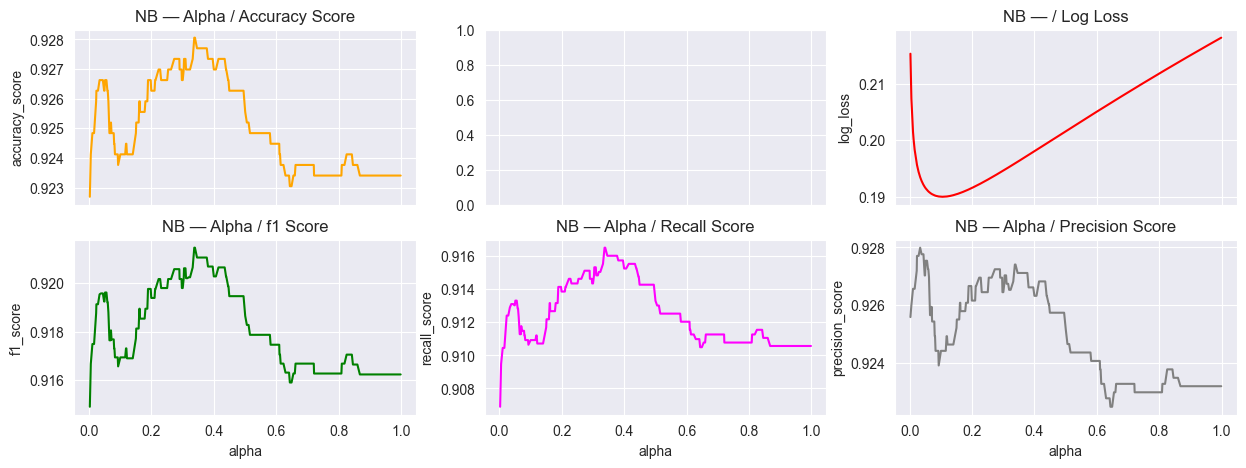

----------------------------------------


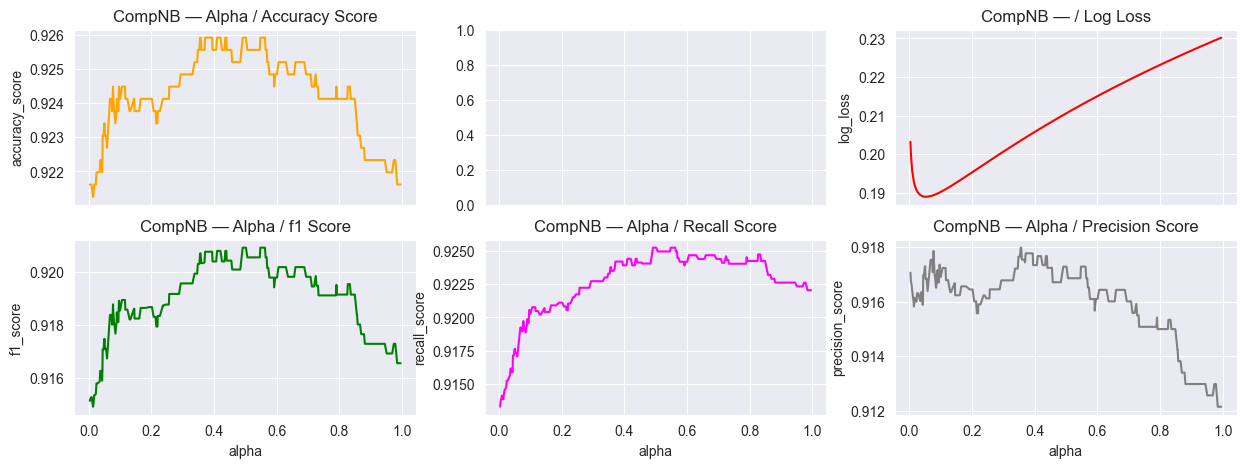

----------------------------------------


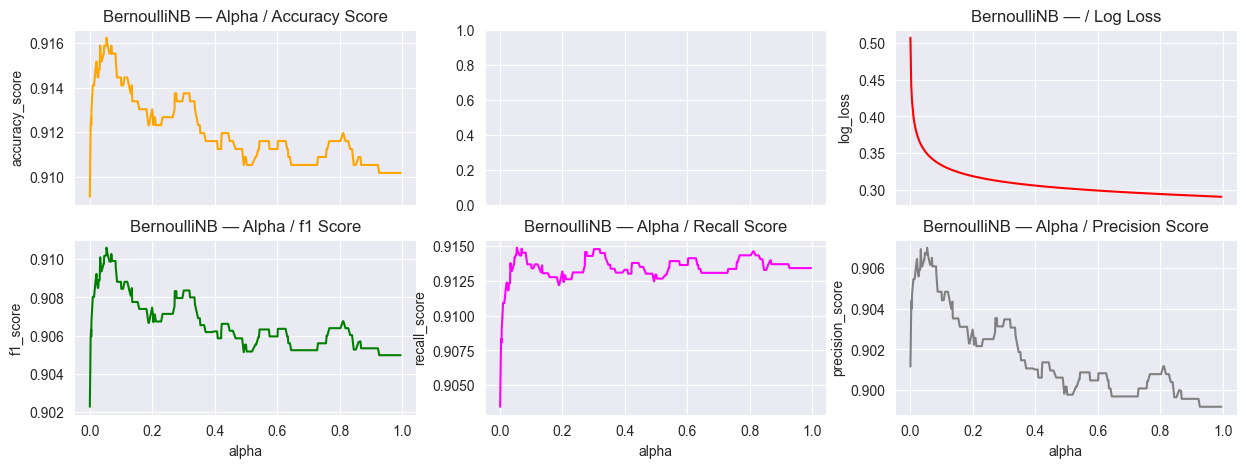

----------------------------------------


In [69]:
# Display results:
def display_results(dataframe, model_name):
    f, axs = plt.subplots(2, 3, figsize=(15, 5), sharex=True)
    sns.lineplot(data=dataframe, x='alpha', y='accuracy_score', color='orange', ax=axs[0][0])
    # sns.lineplot(data=dataframe, x='alpha', y='roc_auc', color='blue', ax=axs[0][1])
    sns.lineplot(data=dataframe, x='alpha', y='log_loss', color='red', ax=axs[0][2])
    sns.lineplot(data=dataframe, x='alpha', y='f1_score', color='green', ax=axs[1][0])
    sns.lineplot(data=dataframe, x='alpha', y='recall_score', color='magenta', ax=axs[1][1])
    sns.lineplot(data=dataframe, x='alpha', y='precision_score', color='grey', ax=axs[1][2])
    axs[0][0].set_title(f"{model_name} — Alpha / Accuracy Score")
    # axs[0][1].set_title(f"{model_name} — Alpha / ROC AUC")
    axs[0][2].set_title(f"{model_name} — / Log Loss")
    axs[1][0].set_title(f"{model_name} — Alpha / f1 Score")
    axs[1][1].set_title(f"{model_name} — Alpha / Recall Score")
    axs[1][2].set_title(f"{model_name} — Alpha / Precision Score")
    plt.show()

_
for model_name in results['model'].unique():
    temp_df = results[results['model'] == model_name]
    display_results(temp_df, model_name)
    print(f"----------------------------------------")

#### Testing

In [70]:
# Concat CV and Train data
X_train_cv = pd.concat([X_train, X_cv], axis=0)
y_train_cv = pd.concat([y_train, y_cv], axis=0)
_
X_train_cv_tdm = tdm_converter(vectorizer, X_train_cv)

In [71]:
# Testing with most accurate alpha value from results:
final_clf = MultinomialNB(alpha=results['alpha'].iloc[0])
_
final_clf.fit(X_train_cv_tdm, y_train_cv)

MultinomialNB(alpha=0.33944940921636724)

In [72]:
X_test_tdm = tdm_converter(vectorizer, X_test)
y_pred = final_clf.predict(X_test_tdm)
y_probas = final_clf.predict_proba(X_test_tdm)
_
display_metrics(final_clf.__class__.__name__, y_test, y_pred, y_probas)

Model: MultinomialNB
Accuracy score: 0.9370529327610873
Recall score: 0.9288694693749016
Precision score: 0.9360015295959021
f1 score: 0.9322005502257336
Log loss 0.18079145500921695
Error: y should be a 1d array, got an array of shape (699, 2) instead.


#### Save models

In [73]:
import pickle

In [74]:
# Save models / load models
def save_model(model: object, file_name: str):
    """
    Converts current model as a Pickle file for later use.
    """
    with open(f"models/{file_name}", 'wb') as f:
        pickle.dump(model, f)

_
save_model(le, 'label_encoder.pkl')
save_model(vectorizer, 'vectorizer.pkl')
save_model(final_clf, 'classifier.pkl')